In [2]:
import numpy as np
import itertools
import jax
import jax.numpy as jnp
import stim
import random
from dataclasses import dataclass, field

In [3]:
key = jax.random.key(0)

In [4]:
def generate_random_rgs_v3(key: jnp.ndarray, num_rows: int, num_cols: int, edges_between_row: int):
    
    nodes = jnp.arange(num_rows * num_cols).reshape((num_rows, num_cols))
    nodes = nodes.tolist()
    
    # Determine node for connection between rows
    is_connected = jnp.ones(shape=(num_cols**2, ), dtype=jnp.bool)
    num_false = num_cols**2 - edges_between_row
    false_indices = jax.random.choice(key, jnp.arange(len(is_connected)), shape=(num_false,), replace=False)    
    is_connected = is_connected.at[false_indices].set(False)
    is_connected = jnp.concatenate((is_connected, is_connected))

    edges = itertools.chain(
        *[itertools.product(nodes[i], nodes[i + 1]) for i in [0, num_rows - 2]]
    )

    def generate_pattern(n:int):
        """
        This function use for generate string pattern for middle node
        """
        result = []
        for i in range(n, 2*n):
            result.append(str(i))       # Add the current number
            result.append(str(i + n))   # Add the current number + n
        
        return ' '.join(result)

    circuit = "H " + " ".join([str(i) for i in range(int(num_cols * num_rows))]) + '\nCZ '
    circuit += ' '.join([ f'{i} {j}' for is_c, (i, j) in zip(is_connected, edges) if is_c])    
    circuit += ' ' + generate_pattern(num_cols)

    return circuit

def generate_random_rgs_random_version(num_rows: int, num_cols: int, edges_between_row: int):
    nodes = np.arange(num_rows * num_cols).reshape((num_rows, num_cols))
    nodes = nodes.tolist()
        
    num_false = num_cols**2 - edges_between_row

    # Create an array of True values
    is_connected = np.array([True] * (num_cols ** 2))
    # Get random indices to set to False
    false_indices = random.sample(range(len(is_connected)), k=num_false)
    # Set the selected indices to False
    for index in false_indices:
        is_connected[index] = False
    is_connected = np.concatenate((is_connected, is_connected))    

    edges = itertools.chain(
        *[itertools.product(nodes[i], nodes[i + 1]) for i in [0, num_rows - 2]]
    )

    circuit = "H " + " ".join([str(i) for i in range(int(num_cols * num_rows))]) + '\nCZ '
    circuit += ' '.join([ f'{i} {j}' for is_c, (i, j) in zip(is_connected, edges) if is_c])
    middle_string = ' '.join(map(str, [i for i in range(num_cols,num_cols*3)]))
    circuit += ' ' + middle_string

    return circuit

def gen_all_bell_v2(num_rows: int, num_cols: int):

    stabilzers = []
    for i, j in itertools.product(range(0, num_cols), range(num_cols*3, num_cols*4)):
        stab = ["_"] * (num_rows * num_cols)
        stab[i] = 'X'
        stab[j] = 'Z'
        stabilzers.append("+" + "".join(stab))

        stab = ["_"] * (num_rows * num_cols)
        stab[j] = 'X'
        stab[i] = 'Z'
        stabilzers.append("+" + "".join(stab))

    return stabilzers



In [4]:
# count = 0
all_bell_stabs = gen_all_bell_v2(num_rows=4, num_cols=3)
bell_each_trial = jnp.array([])

for idx in range(1000):

    # Generate RGS
    key, graph_key = jax.random.split(key, 2)
    circuit = generate_random_rgs_v3(graph_key, 4, 3, edges_between_row=6)

    s = stim.TableauSimulator()
    s.do(stim.Circuit(circuit))

    # Measure X on middle nodes
    for i in range(3, 9):
        s.postselect_x(i, desired_value=False)

    # Measure Z on end nodes
    max_found_bell = 0
    for node_1 in [0, 1, 2]:
        for node_2 in [9, 10, 11]:
            _s = s.copy() # for save the state before measurements z
            _s.postselect_z(node_1, desired_value=False)
            _s.postselect_z(node_2, desired_value=False)    

            # Analyze stabilizers after measurements
            r = _s.canonical_stabilizers()    
            set_r = set(map(str, filter(lambda x: x.weight == 2, r)))

            is_contained_bell_pair = set_r.issubset(
                set(all_bell_stabs)
            )

            if is_contained_bell_pair and len(set_r)/2 > max_found_bell:
                max_found_bell = len(set_r)/2
    
    # count += max_found_bell
    bell_each_trial = jnp.append(bell_each_trial, max_found_bell)


# print(f'Mean from count: {count / 1000}')
print(f'Bell found: {jnp.mean(bell_each_trial)} + {jnp.std(bell_each_trial)}')

Bell found: 1.315000057220459 + 0.7026911973953247


In [5]:
# count = 0
def simulate_rgs(key:jnp.ndarray, num_rows:int, num_cols:int, num_trials:int=1000):
    all_bell_stabs = gen_all_bell_v2(num_rows=num_rows, num_cols=num_cols) 

    # Change number of connected between row
    for edges in range(1, (num_cols**2)+1):

        # Collect number of bells found for calculate mean+-std
        bell_each_trial = jnp.array([])

        # Repeat simulate trial times
        for _ in range(num_trials):

            # Generate RGS with seed
            key, graph_key = jax.random.split(key, 2)
            circuit = generate_random_rgs_v3(graph_key, num_rows, num_cols, edges_between_row=edges)

            s = stim.TableauSimulator()
            s.do(stim.Circuit(circuit))

            # Measure X on middle nodes
            for i in range(num_cols, num_cols*3):
                s.postselect_x(i, desired_value=False)

            # Measure Z on end nodes
            max_found_bell = 0
            for node_1 in range(num_cols):
                for node_2 in range(num_cols*3, num_cols*4):
                    _s = s.copy() # for save the state before measurements z
                    _s.postselect_z(node_1, desired_value=False)
                    _s.postselect_z(node_2, desired_value=False)    

                    # Analyze stabilizers after measurements
                    r = _s.canonical_stabilizers()    
                    set_r = set(map(str, filter(lambda x: x.weight == 2, r)))

                    is_contained_bell_pair = set_r.issubset(
                        set(all_bell_stabs)
                    )

                    if is_contained_bell_pair and len(set_r)/2 > max_found_bell:
                        max_found_bell = len(set_r)/2

            # Collect max bell found each trial            
            bell_each_trial = jnp.append(bell_each_trial, max_found_bell)

        print(f'Num edges connected {edges}, Bell found: {jnp.mean(bell_each_trial)} + {jnp.std(bell_each_trial)}')

simulate_rgs(key, num_rows=4, num_cols=3, num_trials=1000)

Num edges connected 1, Bell found: 0.3270000219345093 + 0.46911725401878357
Num edges connected 2, Bell found: 1.0080000162124634 + 0.6098655462265015
Num edges connected 3, Bell found: 1.340000033378601 + 0.6499230861663818
Num edges connected 4, Bell found: 1.6030000448226929 + 0.5304629802703857
Num edges connected 5, Bell found: 1.5090000629425049 + 0.547648549079895
Num edges connected 6, Bell found: 1.3100000619888306 + 0.7098591327667236
Num edges connected 7, Bell found: 1.443000078201294 + 0.6532618999481201
Num edges connected 8, Bell found: 1.6510000228881836 + 0.47665390372276306
Num edges connected 9, Bell found: 0.0 + 0.0


In [ ]:
from stimrgs_v1.collector import *

def simulate_rgs_V2(key: jnp.ndarray, num_rows: int, num_cols: int, num_trials: int = 1000):
    # Create an experiment for this RGS configuration
    # 📦 Main Collector
    experiment = RGSExperiment(name=f"RGS {num_cols} arms experiment", 
                               description=f"Simulation with num_rows={num_rows}, num_cols={num_cols}, num_trials={num_trials}")
    
    all_bell_stabs = gen_all_bell_v2(num_rows=num_rows, num_cols=num_cols)

    # Change number of connected between row
    for edges in range(1, (num_cols**2) + 1):
        # This represents the arm in our experiment
        experiment.add_arm(edges)

        # Collect number of bells found for calculate mean+-std
        bell_each_trial = jnp.array([])

        # Repeat simulate trial times
        for trial in range(num_trials):
            # Generate RGS with seed
            key, graph_key, meas_1_key, meas_2_key = jax.random.split(key, 4)
            circuit = generate_random_rgs_v3(graph_key, num_rows, num_cols, edges_between_row=edges)

            s = stim.TableauSimulator()
            s.do(stim.Circuit(circuit))

            # Measure X on middle nodes
            for i in range(num_cols, num_cols * 3):
                s.postselect_x(i, desired_value=False)

            # Measure Z on end nodes            
            node_1 = jax.random.choice(meas_1_key, jnp.array([i for i in range(num_cols)]))
            node_2 = jax.random.choice(meas_2_key, jnp.array([i for i in range(num_cols * 3, num_cols * 4)]))
            for i in [node_1, node_2]:
                s.postselect_z(i, desired_value=False)

            r = s.canonical_stabilizers()
            set_r = set(map(str, filter(lambda x: x.weight == 2, r)))

            is_contained_bell_pair = set_r.issubset(set(all_bell_stabs))

            if is_contained_bell_pair:
                bell_value = len(set_r) / 2
                bell_each_trial = jnp.append(bell_each_trial, bell_value)
                
                # Store this individual trial result with metadata
                experiment.add_result_to_arm(
                    edges, 
                    float(bell_value), 
                    metadata={"trial": trial, "node_1": int(node_1), "node_2": int(node_2)}
                )

        # Calculate the statistics using JAX
        if len(bell_each_trial) > 0:
            mean_bells = float(jnp.mean(bell_each_trial))
            std_bells = float(jnp.std(bell_each_trial))
            
            # Print the result as in your original code
            print(f'Num edges connected {edges}, Bell found: {mean_bells} ± {std_bells}')
        else:
            print(f'Num edges connected {edges}, No bell pairs found')
    
    return experiment

def run_rgs_experiments(key, arms_list, num_rows=4, num_trials=1000):
    """Run RGS experiments for multiple arm configurations and return a collection of results"""
    experiments = {}
    
    for arm in arms_list:
        print(f'RGS {arm} arms')
        experiment = simulate_rgs_V2(key, num_rows=num_rows, num_cols=arm, num_trials=num_trials)
        experiments[arm] = experiment
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    return experiments

if __name__ == "__main__":
    key = jax.random.PRNGKey(42)  # Use a fixed seed for reproducibility
    arms_to_test = [3, 4, 5, 6, 7, 8]
    
    # Run all experiments
    all_experiments = run_rgs_experiments(key, arms_to_test)
    
    # Print summary of all experiments
    print("\nSUMMARY OF ALL EXPERIMENTS:")
    for arm, experiment in all_experiments.items():
        summary = experiment.summary()
        best_arm = summary["best_arm"]
        mean = summary["mean_per_arm"][best_arm]
        std = summary["std_per_arm"][best_arm]
        
        print(f"RGS {arm} arms - Best configuration: {best_arm} edges with {mean:.4f} ± {std:.4f} bell pairs")
    
    # You can also analyze results across different arm configurations
    best_overall_arm = max(all_experiments.items(), 
                          key=lambda x: x[1].get_best_arm() is not None and 
                                       x[1].summary()["mean_per_arm"][x[1].get_best_arm()] or 0)[0]
    
    print(f"\nBest overall configuration: RGS with {best_overall_arm} arms")

RGS 3 arms
Num edges connected 1, Bell found: 0.14900000393390656 ± 0.3560885488986969
Num edges connected 2, Bell found: 0.5041322112083435 ± 0.5397270917892456
Num edges connected 3, Bell found: 0.8751432299613953 ± 0.57773756980896
Num edges connected 4, Bell found: 1.0587557554244995 ± 0.4477330148220062
Num edges connected 5, Bell found: 1.0635491609573364 ± 0.4666733741760254
Num edges connected 6, Bell found: 0.9596354365348816 ± 0.5587242841720581
Num edges connected 7, Bell found: 1.0781440734863281 ± 0.5447033643722534
Num edges connected 8, Bell found: 1.4548105001449585 ± 0.49795374274253845
Num edges connected 9, No bell pairs found
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
RGS 4 arms
Num edges connected 1, Bell found: 0.13199999928474426 ± 0.3384908139705658
Num edges connected 2, Bell found: 0.49481329321861267 ± 0.5531633496284485
Num edges connected 3, Bell found: 0.8630536198616028 ± 0.6523748636245728
Num edges connected 4, Bell found: 1

In [10]:
for arm, experiment in all_experiments.items():
    summary = experiment.summary()
    best_arm = summary["best_arm"]
    mean = summary["mean_per_arm"][best_arm]
    std = summary["std_per_arm"][best_arm]
    
    print(f"RGS {arm} arms - Best configuration: {best_arm} edges with {mean:.4f} ± {std:.4f} bell pairs")

RGS 3 arms - Best configuration: 8 edges with 1.4548 ± 0.4983 bell pairs
RGS 4 arms - Best configuration: 13 edges with 1.3619 ± 0.6249 bell pairs
RGS 5 arms - Best configuration: 5 edges with 1.4085 ± 0.7541 bell pairs
RGS 6 arms - Best configuration: 34 edges with 2.1531 ± 0.6862 bell pairs
RGS 7 arms - Best configuration: 8 edges with 1.7533 ± 0.8486 bell pairs
RGS 8 arms - Best configuration: 62 edges with 3.1757 ± 0.8012 bell pairs


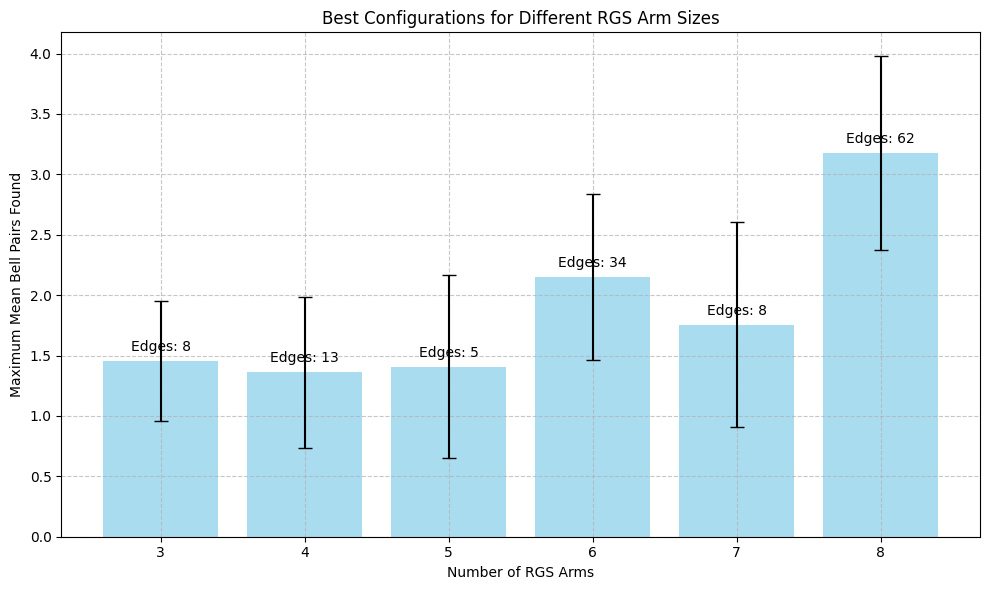

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Best Configurations for Different RGS Arm Sizes'}, xlabel='Number of RGS Arms', ylabel='Maximum Mean Bell Pairs Found'>)

In [12]:
import matplotlib.pyplot as plt

def plot_best_configurations(experiments, save_path=None):
    """
    Plot the best configuration (most Bell pairs) for each arm size.
    
    Args:
        experiments: Dictionary mapping arm sizes to RGSExperiment objects
        save_path: Optional path to save the figure
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    arm_sizes = []
    best_arms = []
    best_means = []
    best_stds = []
    
    for arm_size, experiment in sorted(experiments.items()):
        summary = experiment.summary()
        best_arm = summary["best_arm"]
        
        if best_arm is not None:
            arm_sizes.append(arm_size)
            best_arms.append(best_arm)
            best_means.append(summary["mean_per_arm"][best_arm])
            best_stds.append(summary["std_per_arm"][best_arm])
    
    # Plot with error bars
    ax.bar(arm_sizes, best_means, color='skyblue', alpha=0.7)
    ax.errorbar(arm_sizes, best_means, yerr=best_stds, fmt='none', ecolor='black', capsize=5)
    
    # Add data labels
    for i, (arm_size, best_arm, mean) in enumerate(zip(arm_sizes, best_arms, best_means)):
        ax.annotate(f'Edges: {best_arm}', 
                   (arm_size, mean), 
                   xytext=(0, 5), 
                   textcoords='offset points',
                   ha='center', 
                   va='bottom')
    
    ax.set_xlabel('Number of RGS Arms')
    ax.set_ylabel('Maximum Mean Bell Pairs Found')
    ax.set_title('Best Configurations for Different RGS Arm Sizes')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set x-ticks to be integers
    ax.set_xticks(arm_sizes)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    
    return fig, ax

plot_best_configurations(experiments=all_experiments)

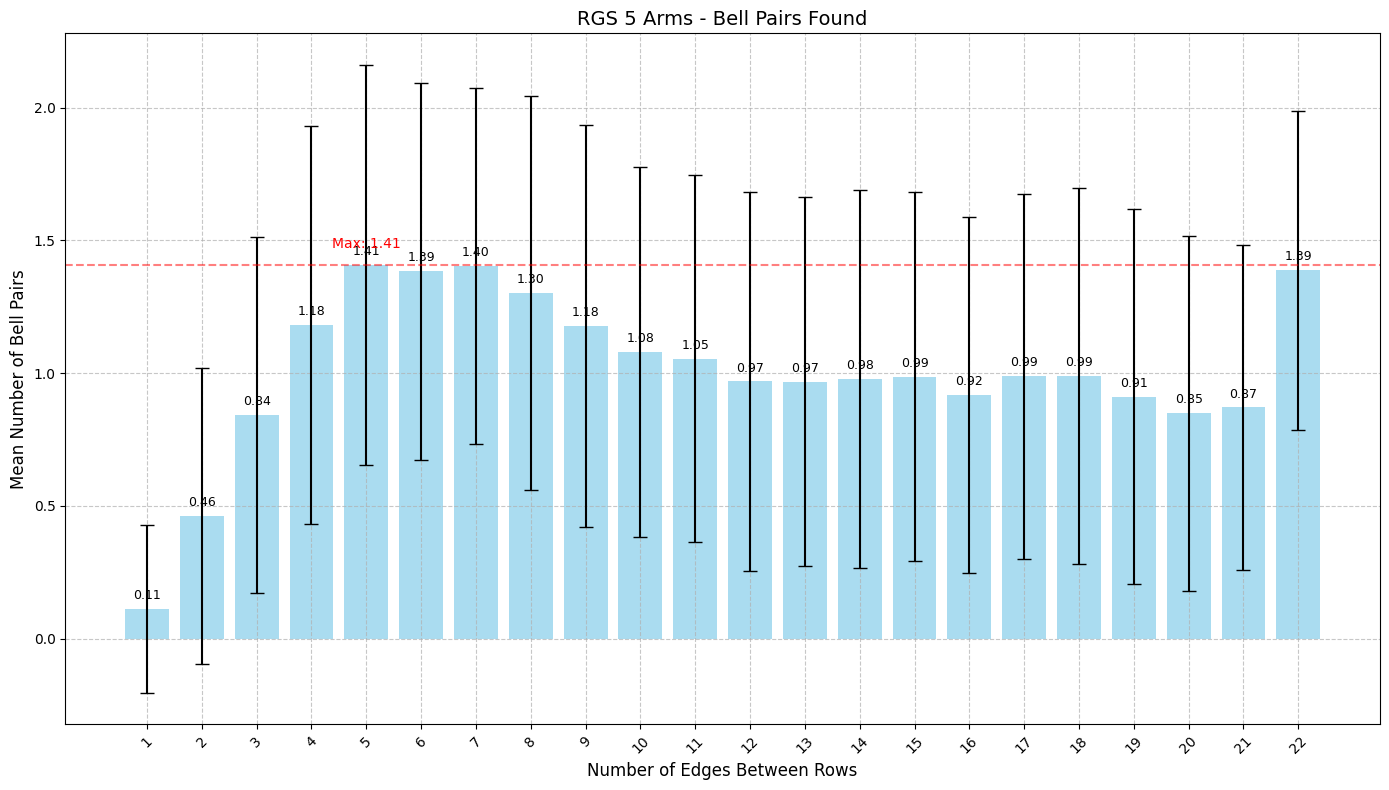

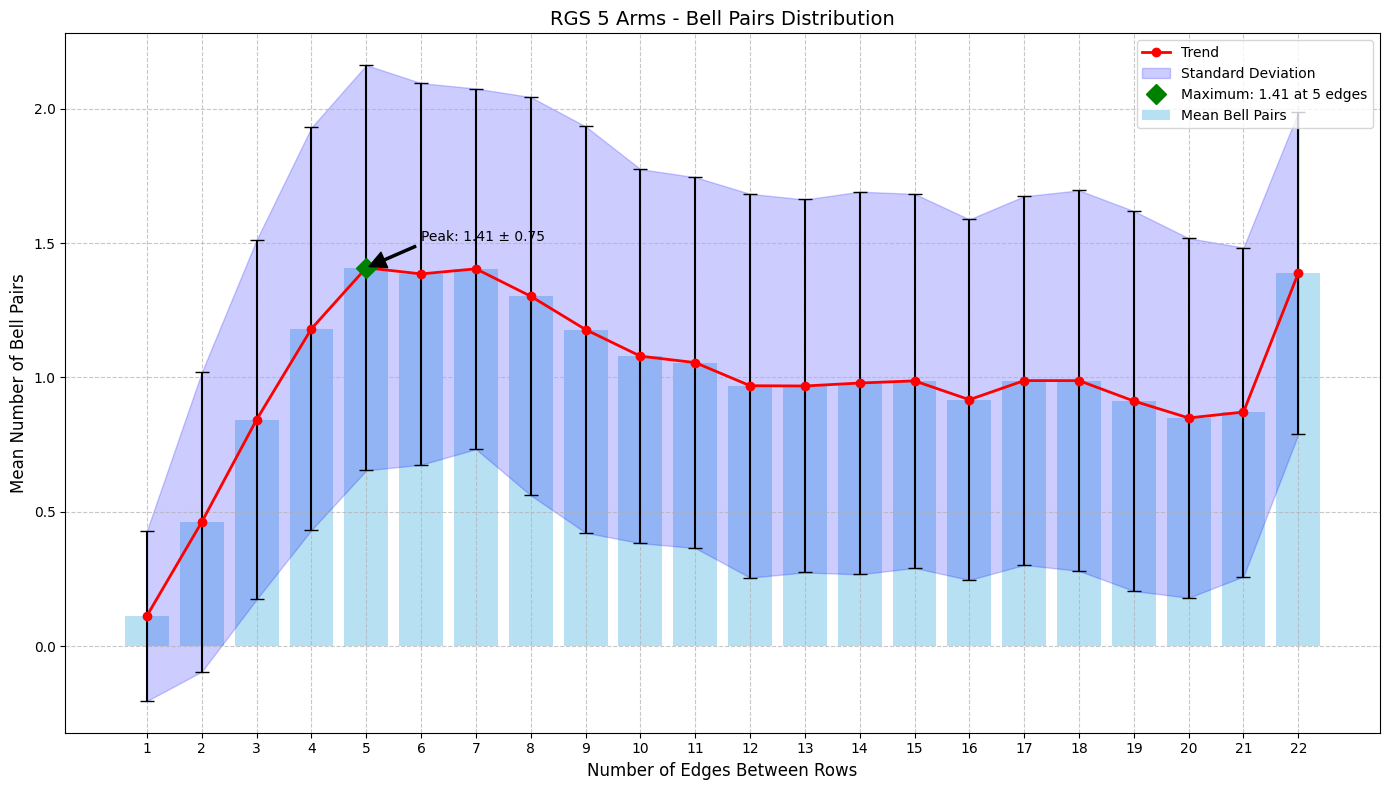

In [13]:
# Data for RGS 5 arms
edges = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
bell_means = [0.113, 0.462, 0.843, 1.181, 1.408, 1.385, 1.404, 1.302, 1.178, 1.079, 
              1.055, 0.969, 0.968, 0.979, 0.987, 0.917, 0.988, 0.988, 0.912, 0.849, 0.871, 1.388]
bell_stds = [0.317, 0.557, 0.669, 0.749, 0.754, 0.710, 0.671, 0.741, 0.756, 0.696, 
             0.690, 0.714, 0.694, 0.712, 0.696, 0.671, 0.686, 0.708, 0.707, 0.669, 0.612, 0.600]

def plot_rgs_histogram(edges, means, stds, title="RGS 5 Arms - Bell Pairs Found"):
    """
    Plot histogram for RGS results with error bars.
    
    Args:
        edges: List of edge counts
        means: List of mean bell pair counts
        stds: List of standard deviations
        title: Plot title
    """
    plt.figure(figsize=(14, 8))
    
    # Create bar plot with error bars
    bars = plt.bar(edges, means, width=0.8, color='skyblue', alpha=0.7)
    plt.errorbar(edges, means, yerr=stds, fmt='none', ecolor='black', capsize=5)
    
    # Add data labels
    for i, (edge, mean) in enumerate(zip(edges, means)):
        plt.annotate(f'{mean:.2f}', 
                    xy=(edge, mean),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', 
                    va='bottom',
                    fontsize=9)
    
    # Customize plot
    plt.xlabel('Number of Edges Between Rows', fontsize=12)
    plt.ylabel('Mean Number of Bell Pairs', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Set x-ticks to be integers
    plt.xticks(edges)
    
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45)
    
    # Add horizontal line at peak value
    max_mean = max(means)
    plt.axhline(y=max_mean, color='red', linestyle='--', alpha=0.5)
    plt.annotate(f'Max: {max_mean:.2f}', 
                xy=(edges[means.index(max_mean)], max_mean),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                va='bottom',
                color='red',
                fontsize=10)
    
    plt.tight_layout()
    plt.savefig('rgs_5_arms_histogram.png', dpi=300)
    plt.show()

# Plot the histogram
plot_rgs_histogram(edges, bell_means, bell_stds)

# Function to create a more detailed plot with a line graph overlay
def plot_rgs_detailed(edges, means, stds, title="RGS 5 Arms - Bell Pairs Distribution"):
    """
    Create a more detailed plot with both histogram and line graph for RGS results.
    
    Args:
        edges: List of edge counts
        means: List of mean bell pair counts
        stds: List of standard deviations
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create bar plot with error bars
    bars = ax.bar(edges, means, width=0.8, color='skyblue', alpha=0.6, label='Mean Bell Pairs')
    ax.errorbar(edges, means, yerr=stds, fmt='none', ecolor='black', capsize=5)
    
    # Add line plot to show trend
    ax.plot(edges, means, 'ro-', linewidth=2, markersize=6, label='Trend')
    
    # Shade area between mean±std
    ax.fill_between(edges, 
                   np.array(means) - np.array(stds), 
                   np.array(means) + np.array(stds), 
                   color='blue', alpha=0.2, label='Standard Deviation')
    
    # Highlight maximum point
    max_idx = np.argmax(means)
    max_edge = edges[max_idx]
    max_mean = means[max_idx]
    ax.plot(max_edge, max_mean, 'D', color='green', markersize=10, label=f'Maximum: {max_mean:.2f} at {max_edge} edges')
    
    # Customize plot
    ax.set_xlabel('Number of Edges Between Rows', fontsize=12)
    ax.set_ylabel('Mean Number of Bell Pairs', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set x-ticks to be integers
    ax.set_xticks(edges)
    
    # Add legend
    ax.legend(loc='upper right')
    
    # Add text annotation for peak value
    ax.annotate(f'Peak: {max_mean:.2f} ± {stds[max_idx]:.2f}', 
               xy=(max_edge, max_mean),
               xytext=(max_edge + 1, max_mean + 0.1),
               arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
               fontsize=10)
    
    plt.tight_layout()
    plt.savefig('rgs_5_arms_detailed.png', dpi=300)
    plt.show()

# Plot the detailed version
plot_rgs_detailed(edges, bell_means, bell_stds)